In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
class DataLoader():
    def __init__(self):
        self._data_path = "../../data/"

    def loadCsv(self, file_name):
        with open(os.path.join(self._data_path, file_name)) as f:
            csv = pd.read_csv(f)
    
        return csv

In [16]:
dl = DataLoader()
df_id = dl.loadCsv("train_identity.csv")
df_tr = dl.loadCsv("train_transaction.csv")

## Transaction Table
IP, ISP, Proxy, UA, browser, os, etc.associated with the transactions. Field names are masked for privacy

**Cateogorical features**: DeviceType, DeviceInfo, id_12-id_38

In [4]:
df_id
# Some of these variables may or may not be useful. id_33 shows resolution. Low resolution could be correlated with fraud, as older less secure devices will generally have poorer resolution

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144228,3577521,-15.0,145955.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 66.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,F3111 Build/33.3.A.1.97
144229,3577526,-5.0,172059.0,NaN,NaN,1.0,-5.0,NaN,NaN,NaN,...,chrome 55.0 for android,32.0,855x480,match_status:2,T,F,T,F,mobile,A574BL Build/NMF26F
144230,3577529,-20.0,632381.0,NaN,NaN,-1.0,-36.0,NaN,NaN,NaN,...,chrome 65.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,Moto E (4) Plus Build/NMA26.42-152
144231,3577531,-5.0,55528.0,0.0,0.0,0.0,-7.0,NaN,NaN,0.0,...,chrome 66.0,24.0,2560x1600,match_status:2,T,F,T,F,desktop,MacOS


In [5]:
# we see that id_31 is a string with formatting browser + version + OS (sometimes)
# Let's extract the version and browser to use as separate variables
pattern = r'^(.*?)(\d+(?:\.\d+)*)(.*)$'
df_id[['browser', 'version', 'platform']] = df_id['id_31'].str.extract(pattern, expand=True)

# Now let's get all of those that don't include a version number
pattern = r'^([^0-9]*)$'
df_tmp = pd.DataFrame()
df_tmp["browser"] = df_id['id_31'].str.extract(pattern, expand=True)
df_tmp.dropna(inplace=True)

# add these back into the original dataframe
df_id.loc[df_id["browser"].isnull(), "browser"] = df_tmp

# drop the old column
df_id.drop("id_31", inplace=True, axis=1)

In [6]:
# let's see which rows contain useful data
for col in df_id.columns:
    print( (len(df_id) - df_id[col].isna().sum()) / len(df_id) *100, f" % of rows contain values for {col}")

# We should throw out anything that is sparesely populated or replace NaN with dummy values

100.0  % of rows contain values for TransactionID
100.0  % of rows contain values for id_01
97.66974270797945  % of rows contain values for id_02
45.983928781901504  % of rows contain values for id_03
45.983928781901504  % of rows contain values for id_04
94.8915990099353  % of rows contain values for id_05
94.8915990099353  % of rows contain values for id_06
3.5740780542594273  % of rows contain values for id_07
3.5740780542594273  % of rows contain values for id_08
51.94788987263663  % of rows contain values for id_09
51.94788987263663  % of rows contain values for id_10
97.74323490463348  % of rows contain values for id_11
100.0  % of rows contain values for id_12
88.27383469802334  % of rows contain values for id_13
55.49631499032815  % of rows contain values for id_14
97.74808816290307  % of rows contain values for id_15
89.67434637010948  % of rows contain values for id_16
96.62767882523417  % of rows contain values for id_17
31.27786290238711  % of rows contain values for id_18


TransactionDT: timedelta from a given reference datetime (not an actual timestamp)
TransactionAMT: transaction payment amount in USD

ProductCD: product code, the product for each transaction

card1 - card6: payment card information, such as card type, card category, issue bank, country, etc.

addr: address

dist: distance

P_ and (R__) emaildomain: purchaser and recipient email domain

C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.

D1-D15: timedelta, such as days between previous transaction, etc.

M1-M9: match, such as names on card and address, etc.

Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.

Categorical Features:
ProductCD, 
P_emaildomain, 
R_emaildomain, 
M1 - M9

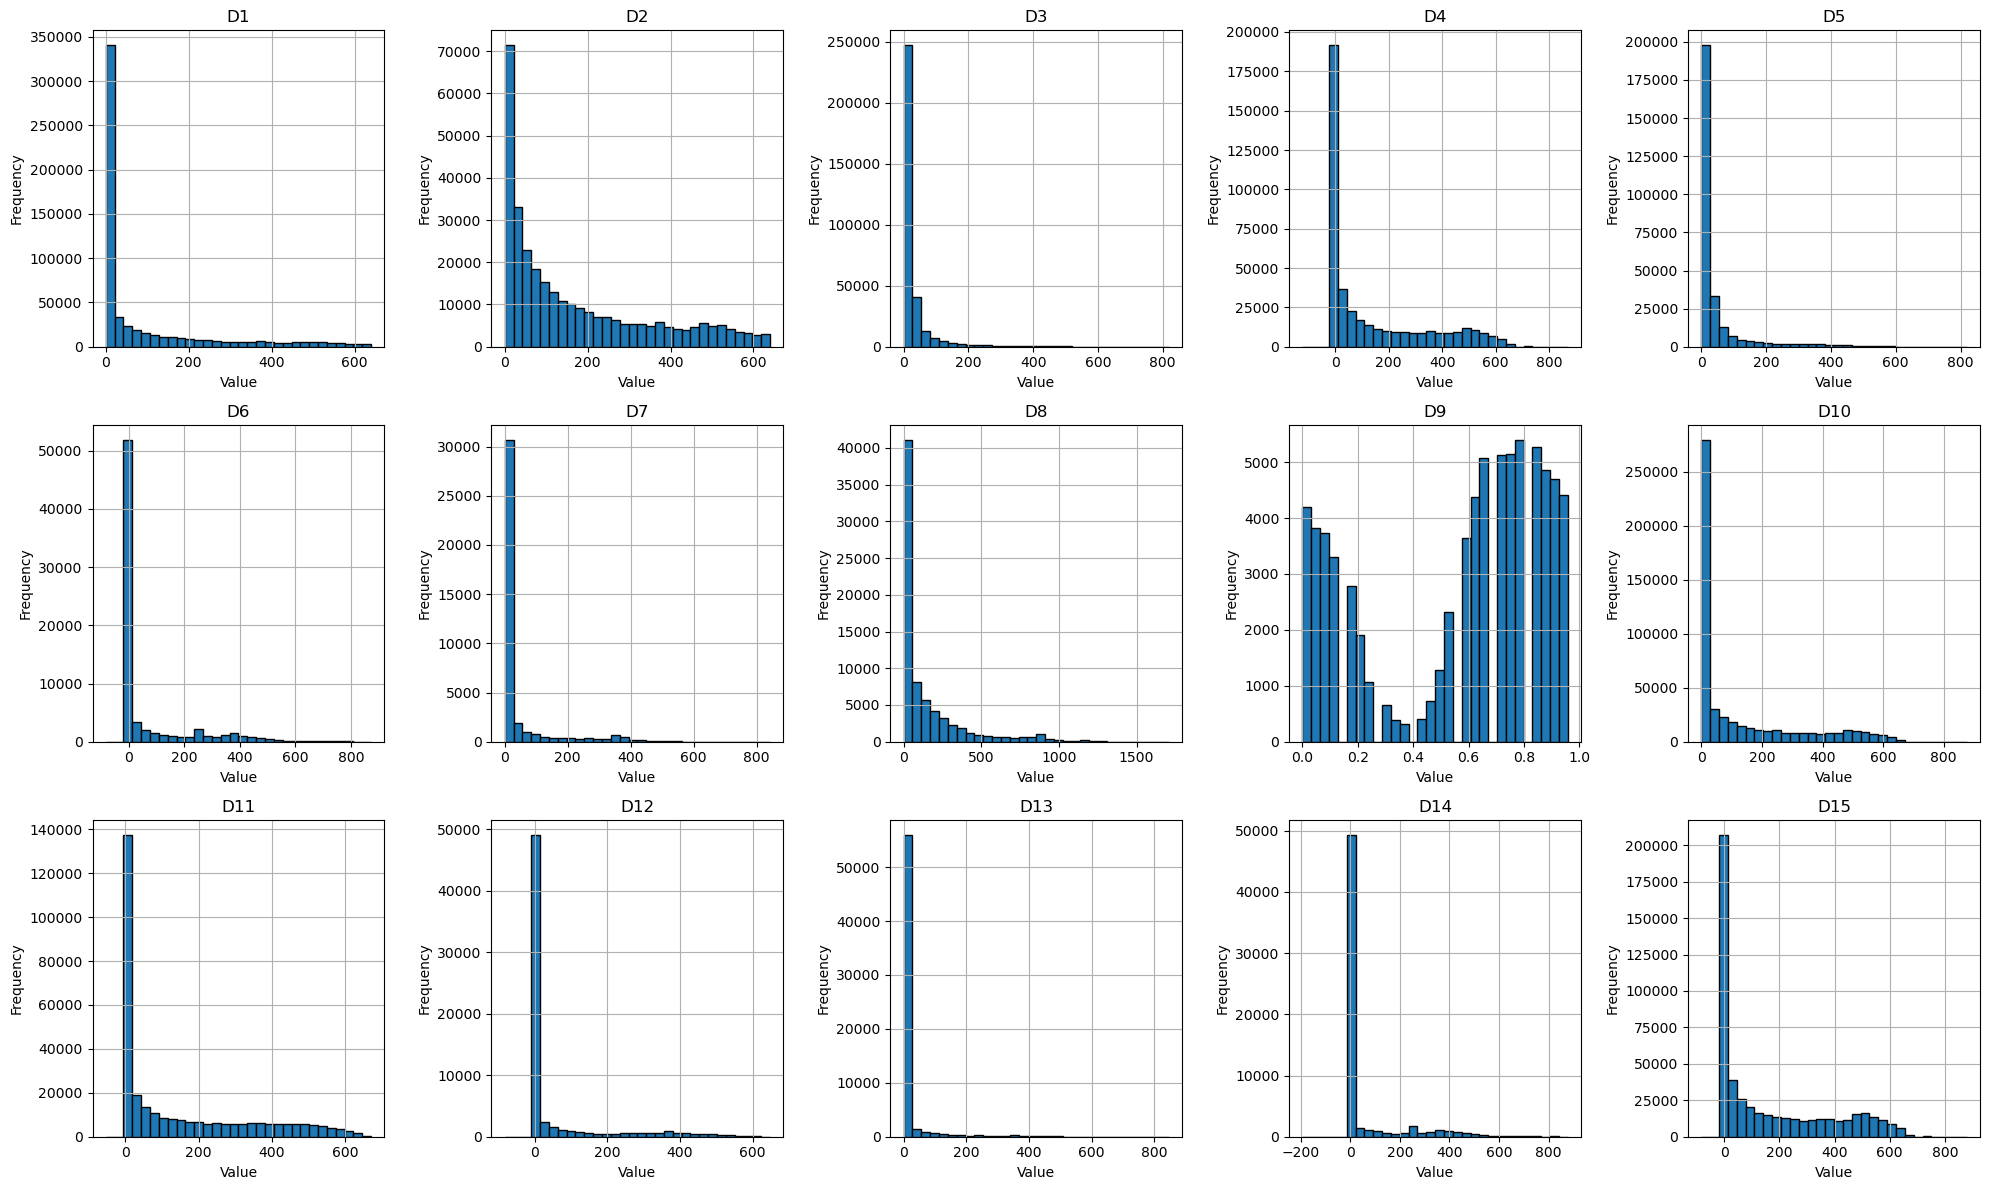

In [13]:
# Filter just the D1-D15 columns
d_columns = [f'D{i}' for i in range(1, 16)]
df = df_tr[d_columns]  # replace `df` with your actual DataFrame

# Set up the grid
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(20, 12))
axes = axes.flatten()  # flatten to easily iterate over

# Plot histograms
for i, col in enumerate(d_columns):
    df[col].hist(ax=axes[i], bins=30, edgecolor='black')
    axes[i].set_title(col)
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')

# Tight layout
plt.tight_layout()
plt.show()

In [11]:
df_tr

,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15
0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0
1,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0
2,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,315.0,NaN,NaN,NaN,315.0
3,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,84.0,NaN,NaN,NaN,NaN,111.0
4,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,29.0,29.0,30.0,NaN,NaN,NaN,NaN,NaN,NaN,56.0,56.0,NaN,NaN,NaN,56.0
590536,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0.0
590537,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0.0
590538,22.0,22.0,0.0,22.0,0.0,NaN,NaN,NaN,NaN,22.0,22.0,NaN,NaN,NaN,22.0


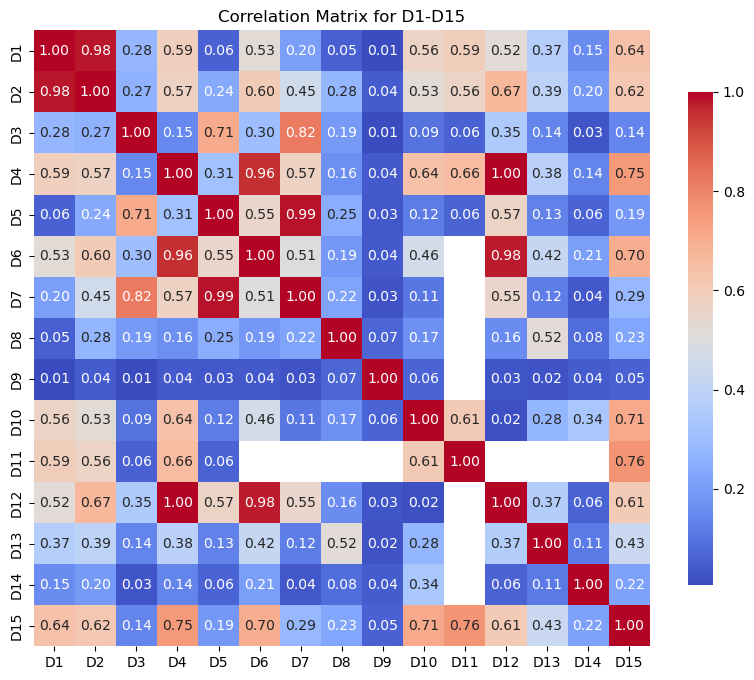

In [19]:
def draw_corr_matrix(var_prefix:str, first:int, last:int):
    d_columns = [f'{var_prefix}{i}' for i in range(first, last)]
    df = df_tr[d_columns]
    
    # Compute the correlation matrix
    corr_matrix = df.corr()
    
    # Plot the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
    plt.title('Correlation Matrix for D1-D15')
    plt.show()

draw_corr_matrix("D",1,16)

In [ ]:
"""
Sinusoidal encoding for time information?
How many of these are linear combinations of each other? Does it matter (yes for linear regression)?
"""

In [27]:
df_tr.describe()

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
count,5.905400e+05,590540.000000,5.905400e+05,590540.000000,590540.000000,581607.000000,588975.000000,586281.000000,524834.000000,524834.000000,...,82351.000000,82351.000000,82351.000000,82351.000000,82351.000000,82351.00000,82351.000000,82351.000000,82351.000000,82351.000000
mean,3.282270e+06,0.034990,7.372311e+06,135.027176,9898.734658,362.555488,153.194925,199.278897,290.733794,86.800630,...,0.775874,721.741883,1375.783644,1014.622782,9.807015,59.16455,28.530903,55.352422,151.160542,100.700882
std,1.704744e+05,0.183755,4.617224e+06,239.162522,4901.170153,157.793246,11.336444,41.244453,101.741072,2.690623,...,4.727971,6217.223583,11169.275702,7955.735482,243.861391,387.62948,274.576920,668.486833,1095.034387,814.946722
min,2.987000e+06,0.000000,8.640000e+04,0.251000,1000.000000,100.000000,100.000000,100.000000,100.000000,10.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,3.134635e+06,0.000000,3.027058e+06,43.321000,6019.000000,214.000000,150.000000,166.000000,204.000000,87.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
50%,3.282270e+06,0.000000,7.306528e+06,68.769000,9678.000000,361.000000,150.000000,226.000000,299.000000,87.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
75%,3.429904e+06,0.000000,1.124662e+07,125.000000,14184.000000,512.000000,150.000000,226.000000,330.000000,87.000000,...,0.000000,0.000000,25.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
max,3.577539e+06,1.000000,1.581113e+07,31937.391000,18396.000000,600.000000,231.000000,237.000000,540.000000,102.000000,...,55.000000,160000.000000,160000.000000,160000.000000,55125.000000,55125.00000,55125.000000,104060.000000,104060.000000,104060.000000


In [30]:
# Find correlations with fraud
corr_fraud = df_tr.corrwith(df_tr["isFraud"], numeric_only=True)

# Find least correlated variables
corr_fraud = np.abs(corr_fraud).sort_values(ascending=True)

In [34]:
# Organize columns which are equally sparsley populated
cols = []
col_dict = {}
for col in df_tr.columns:
    percent_pop = (len(df_tr) - df_tr[col].isna().sum()) / len(df_tr) *100 # percent of rows which are not NaN
    percent_pop = round(percent_pop, 2)
    
    if not percent_pop in col_dict.keys():
        col_dict[percent_pop] = []

    col_dict[percent_pop].append(col)
    print( percent_pop, f" % of rows contain values for {col}")

100.0  % of rows contain values for TransactionID
100.0  % of rows contain values for isFraud
100.0  % of rows contain values for TransactionDT
100.0  % of rows contain values for TransactionAmt
100.0  % of rows contain values for ProductCD
100.0  % of rows contain values for card1
98.49  % of rows contain values for card2
99.73  % of rows contain values for card3
99.73  % of rows contain values for card4
99.28  % of rows contain values for card5
99.73  % of rows contain values for card6
88.87  % of rows contain values for addr1
88.87  % of rows contain values for addr2
40.35  % of rows contain values for dist1
6.37  % of rows contain values for dist2
84.01  % of rows contain values for P_emaildomain
23.25  % of rows contain values for R_emaildomain
100.0  % of rows contain values for C1
100.0  % of rows contain values for C2
100.0  % of rows contain values for C3
100.0  % of rows contain values for C4
100.0  % of rows contain values for C5
100.0  % of rows contain values for C6
100.0 

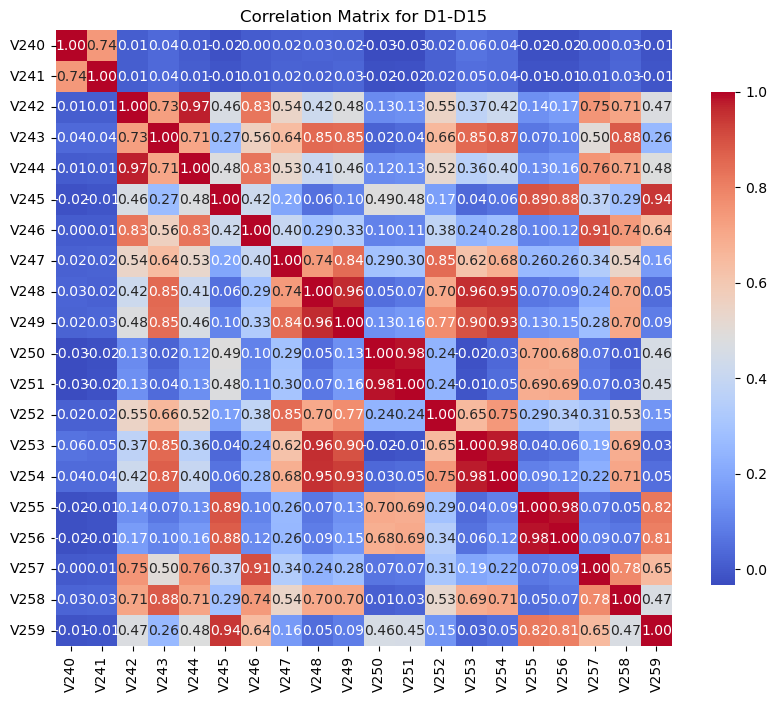

In [22]:
# Select the D1-D15 columns
draw_corr_matrix("V",240,260)

In [115]:
# Look at correlation between variables which are sparsely populated
"""
Many variables are sparsley populated. And many appear to be sparsley populated in the same way.
For variables which are sparsley populated in the same way, find out which ones are correlated with each other.
Of the ones which are highly correlated, only keep the one which is most highly correlated with isFraud.
Alternatively: Only keep the one which  has the most unique values
"""
vars_to_keep = []
for percent in col_dict.keys():
    if percent < 50 and len(col_dict[percent]) > 1:
        corr_sparse = df_tr[col_dict[percent]].corr(numeric_only=True)    

        strong_corr = corr_sparse.where((corr_sparse.abs() > 0.75) & (corr_sparse.abs() < 1.0))
        # Do we want to keep sparsley popoulated variables if they aren't correlated with other variables?
        # nan_columns = strong_corr.columns[strong_corr.isna().all()]
        # vars_to_keep += list(nan_columns)
        
        strong_corr_pairs = strong_corr.stack().reset_index()
        strong_corr_pairs.columns = ['Variable 1', 'Variable 2', 'Correlation']
        if len(strong_corr_pairs) == 0: continue
        # remove duplicate pairs
        strong_corr_pairs = strong_corr_pairs[strong_corr_pairs['Variable 1'] < strong_corr_pairs['Variable 2']]
        
        # Find variable most highly correlated with isFraud
        vars_with_strong_corr = pd.unique(
            strong_corr_pairs[['Variable 1', 'Variable 2']].values.ravel()
        )

        ## Keep the variable that is most highy correlated with isFraud
        # corr_fraud = df_tr[vars_with_strong_corr].corrwith(df_tr["isFraud"], numeric_only=True).abs()
        # vars_to_keep.append(corr_fraud.idxmax())

        ## Alternatively, keep the variable with the most unique values
        # vars_to_keep.append(df_tr[vars_with_strong_corr].nunique().idxmax())
        
        ## Or combine the two. Take the variable with the most unique values of the variables which are correlated with isFraud above some threshold
        corr_fraud = df_tr[vars_with_strong_corr].corrwith(df_tr["isFraud"], numeric_only=True).abs() > 0.25 # must be 0.25 correlated
        # select only true values from mask
        corr_fraud = corr_fraud[corr_fraud].index
        # If there are no variables passing the threshold then don't use them
        if len(corr_fraud) < 1:
            continue
            
        vars_to_keep.append(df_tr[corr_fraud].nunique().idxmax())
    else:
        vars_to_keep += col_dict[percent]

In [116]:
df_tr_keep = df_tr[vars_to_keep]
# do we want to prune these even further?

In [35]:
# Categorical encoding
"""
which cateogories should be one-hot-encoded vs. ordinal encoded vs. another method such as frequency encoding?

ProductCD has 5 categories. Don't seem to be ordinal. One hot encode
card1-card6:
    card4 and card6 are definitely categorical
    card1, card2 are strings of numbers. Maybe identifiers? Combine with ID information?
    card2 3 digit code
    card3 150 cardinality
    card5 some other 3 digit code

Combine many of these with ID to create unique identifier?
M1-M9 are boolean. Convert this to OHE so we have True,False,NaN

"""


'\nwhich cateogories should be one-hot-encoded vs. another method such as frequency encoding?\n'

In [121]:
df_tr[["ProductCD", "card1","card2","card3","addr1", "addr2", "P_emaildomain", "R_emaildomain", "M1", "M2"]]

,ProductCD,card1,card2,card3,addr1,addr2,P_emaildomain,R_emaildomain,M1,M2
0,W,13926,NaN,150.0,315.0,87.0,NaN,NaN,T,T
1,W,2755,404.0,150.0,325.0,87.0,gmail.com,NaN,NaN,NaN
2,W,4663,490.0,150.0,330.0,87.0,outlook.com,NaN,T,T
3,W,18132,567.0,150.0,476.0,87.0,yahoo.com,NaN,NaN,NaN
4,H,4497,514.0,150.0,420.0,87.0,gmail.com,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
590535,W,6550,NaN,150.0,272.0,87.0,NaN,NaN,T,T
590536,W,10444,225.0,150.0,204.0,87.0,gmail.com,NaN,T,F
590537,W,12037,595.0,150.0,231.0,87.0,gmail.com,NaN,T,F
590538,W,7826,481.0,150.0,387.0,87.0,aol.com,NaN,T,T


In [139]:
df_tr['card4'].value_counts(dropna=False)
df_tr.groupby('card4')['isFraud'].mean()

card4
american express    0.028698
discover            0.077282
mastercard          0.034331
visa                0.034756
Name: isFraud, dtype: float64